In [1]:
!nvidia-smi

Mon May  6 00:00:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:61:00.0 Off |                  Off |
|  0%   34C    P8              13W / 450W |      3MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Install all the required libraries

In [2]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 358.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [30]:
!pip install tensorboard

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 85.6 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 100.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python

# Import all the required librabries

In [7]:
import os
import torch
from datasets import load_dataset

from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)

from peft import LoraConfig, PeftModel
from trl import SFTTrainer

# Llama2 Prompt

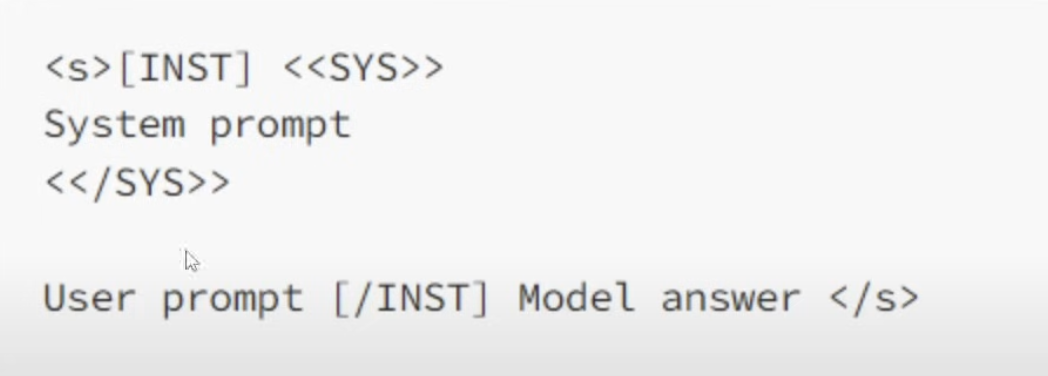

dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

1k dataset: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

https://huggingface.co/datasets/mlabonne/guanaco-llama2

# Load the model from huggin face

In [8]:
model_name = 'meta-llama/Llama-2-7b-chat-hf' # Model from hugging face

new_model = 'llama-2-7b-chat-gunnaco-hf' # my new fine tuned model name

dataset_name = 'mlabonne/guanaco-llama2-1k' # dataset

# QLoRa Config

In [9]:
# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16 # this will always be 1/4 of lora_r

# Dropout probability of LoRA layers
lora_dropout = 0.1

# Bits and Bytes Parameters

In [11]:
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = 'float16'

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = 'nf4'

# Activate nested quantization for 4 bit base models (double quantization)
use_nested_quant = False

# Training Arguments Parameters

In [13]:
# output directory where the model predictions and checkpoint will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to true with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Inital learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# optimizer to use
optim = "paged_adamw_32bit"

#learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (override num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

# SFT Parameters

In [14]:
# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"" : 0}

# Load everything and start the fine tuning process

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [16]:
# Load the dataset
dataset = load_dataset(dataset_name, split = "train")

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [17]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

In [18]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = use_4bit,
    bnb_4bit_quant_type = bnb_4bit_quant_type,
    bnb_4bit_compute_dtype = compute_dtype,
    bnb_4bit_use_double_quant = use_nested_quant
)

In [19]:
# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

Your GPU supports bfloat16: accelerate training with bf16=True


In [21]:
# Load the base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    device_map = device_map
)

model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [23]:
# Load LLaMa Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code = True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_size = "right" # Fix the weird overflow issue with fp16 training

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [27]:
# Load LoRA config
peft_config = LoraConfig(
    lora_alpha = lora_alpha,
    lora_dropout= lora_dropout,
    r = lora_r,
    bias = 'none',
    task_type="CAUSAL_LM"
)

In [28]:
# Set Training parameters
training_arguments = TrainingArguments(
    output_dir = output_dir,
    num_train_epochs = num_train_epochs,
    per_device_train_batch_size = per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps = save_steps,
    logging_steps = logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16 = fp16,
    bf16 = bf16,
    max_grad_norm = max_grad_norm,
    max_steps = max_steps,
    warmup_ratio = warmup_ratio,
    group_by_length = group_by_length,
    lr_scheduler_type = lr_scheduler_type,
    report_to = "tensorboard"
)

In [31]:
# Set SFT : Supervised finetuning parameters
trainer = SFTTrainer(
    model = model,
    train_dataset=dataset,
    peft_config = peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [32]:
# Train the model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,1.412400
50,1.658300
75,1.226400
100,1.459500
125,1.189900
150,1.382400
175,1.184900
200,1.482400
225,1.168300
250,1.552400


TrainOutput(global_step=250, training_loss=1.3716811065673828, metrics={'train_runtime': 245.004, 'train_samples_per_second': 4.082, 'train_steps_per_second': 1.02, 'total_flos': 8773998173061120.0, 'train_loss': 1.3716811065673828, 'epoch': 1.0})

# Save finetuned model

In [33]:
trainer.model.save_pretrained(new_model)

In [42]:
trainer.tokenizer.save_pretrained(new_model)

('llama-2-7b-chat-gunnaco/tokenizer_config.json',
 'llama-2-7b-chat-gunnaco/special_tokens_map.json',
 'llama-2-7b-chat-gunnaco/tokenizer.json')

# Check tensorboard

In [40]:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir results/runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
!kill 2054

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Test the model

In [41]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(
            in_features=4096, out_features=4096, bias=False
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=64, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=64, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(
            in_features=4096, out_features=4096, bias=False
            (lora_dropout): ModuleDict(
              (default): 

In [44]:
# Ignore warning
logging.set_verbosity(logging.CRITICAL)

# Run the text generation pipeline with out next model
prompt = "What is LLM?"
pipe = pipeline(task = "text-generation", model = model, tokenizer=tokenizer, max_length=200)
result = pipe(f'<s>[INST] {prompt} [/INST]</s>')

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [45]:
result

[{'generated_text': '<s>[INST] What is LLM? [/INST]</s> The Master of Laws (LLM) is a postgraduate degree that focuses on advanced legal studies. It is typically a one-year program that provides students with specialized knowledge and skills in a particular area of law, such as corporate law, intellectual property law, or international law.\n\nThe LLM program is designed for law school graduates who want to further their legal education and gain expertise in a specific area of law. It is also suitable for non-lawyers who want to gain a deeper understanding of legal principles and concepts.\n\nThe LLM program typically includes coursework, research, and sometimes a thesis or project. Students in an LLM program can choose from a wide range of courses, including electives and specialized courses. They can also work with a faculty advisor to design a customized program that meets their career goals.\n\nGr'}]

# Store the Model

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Push model to HF Hub

In [48]:
!huggingface-cli login

model.push_to_hub("workspace/llama-2-7b-chat-gunnaco", check_pr=True)

tokenizer.push_to_hub("workspace/llama-2-7b-chat-gunnaco",check_pr=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


OSError: workspace/llama-2-7b-chat-gunnaco is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.